In [1]:
%cd ../..
%load_ext autoreload

%autoreload 2

/home/giacomowsl/Projects/sinergia/emplusvault


In [2]:
import os
import json
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from rts.features.pose import compute_human_angles, reshape_keypoints
import rts.features.pose as pose
import umap
import cv2

/home/giacomowsl/.cache/pypoetry/virtualenvs/rts-o0uzL038-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
poses_folder = "data/test_poses/"
poses_jl = [poses_folder + f for f in os.listdir(poses_folder)]
poses = []
for pose_json in poses_jl:
    extracted_data = pose.extract_frame_data(pose_json, 0.5)
    if len(extracted_data.keys()) > 0:
        pose_exp = [[{"frame_number":k, "angle_vec":angle, "keypoints":keypoint, "bbox":bbox} for angle,keypoint,bbox in zip(v["angle_vec"], v["keypoints"], v["bbox"])] for k,v in extracted_data.items()]
        pose_exp = [item for sublist in pose_exp for item in sublist]
        [p.update({"video_name":pose_json.split("/")[-1].split(".")[0]}) for p in pose_exp]
        poses.extend(pose_exp)

print(len(poses))

14311


In [4]:
from rts.utils import dataframe_from_hdf5

archiva_path = "/mnt/g/ioc/data/"
data = dataframe_from_hdf5(archiva_path, "metadata")

In [5]:
poses_df = pd.DataFrame(poses)
poses_df = pd.merge(poses_df, data[["seq_id", "sport"]], left_on="video_name", right_on="seq_id")
poses_df.head()

,frame_number,angle_vec,keypoints,bbox,video_name,seq_id,sport
0,0,"[0.8966219822240752, 0.12351974652222208, 0.93...","[(561.54, 243.19, 0.68), (564.89, 239.32, 0.7)...","[520.16, 236.84, 65.75, 155.89]",MDA42762820,MDA42762820,Badminton
1,0,"[0.47225142455350166, 0.019543982729455157, 0....","[(682.45, 233.91, 0.91), (686.25, 230.79, 0.95...","[653.96, 227.09, 57.25, 146.46]",MDA42762820,MDA42762820,Badminton
2,0,"[0.7299774586886015, 0.7779588370664416, 0.0, ...","[(373.86, 139.99, 0.75), (376.09, 137.43, 0.76...","[350.89, 135.6, 47.18, 68.36]",MDA42762820,MDA42762820,Badminton
3,0,"[0.874887830173097, 0.7476038746293181, 0.0, 0...","[(880.54, 140.84, 0.69), (882.94, 138.21, 0.75...","[856.13, 136.63, 50.63, 69.9]",MDA42762820,MDA42762820,Badminton
4,0,"[0.8483411499350413, 0.8139497219569558, 0.565...","[(94.36, 324.5, 0.56), (0.0, 0.0, 0.0), (90.02...","[70.34, 321.04, 82.27, 132.02]",MDA42762820,MDA42762820,Badminton


# Missing keypoints

In [ ]:
poses_df["n_missing_keypoints"] = poses_df.keypoints.map(lambda x: len([k for k in x if k[2] == 0]))
poses_df["n_missing_keypoints"].value_counts().sort_index().plot(kind="bar")
plt.xticks(rotation=0)  
plt.title("Cumulative number of poses with at least N missing keypoints")
plt.show()

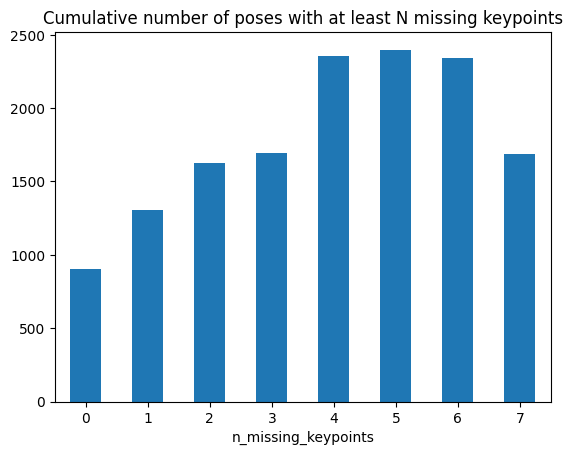

In [6]:
poses_df["n_missing_keypoints"] = poses_df.keypoints.map(lambda x: len([k for k in x if k[2] == 0]))
poses_df["n_missing_keypoints"].value_counts().sort_index().plot(kind="bar")
plt.xticks(rotation=0)  
plt.title("Cumulative number of poses with at least N missing keypoints")
plt.show()

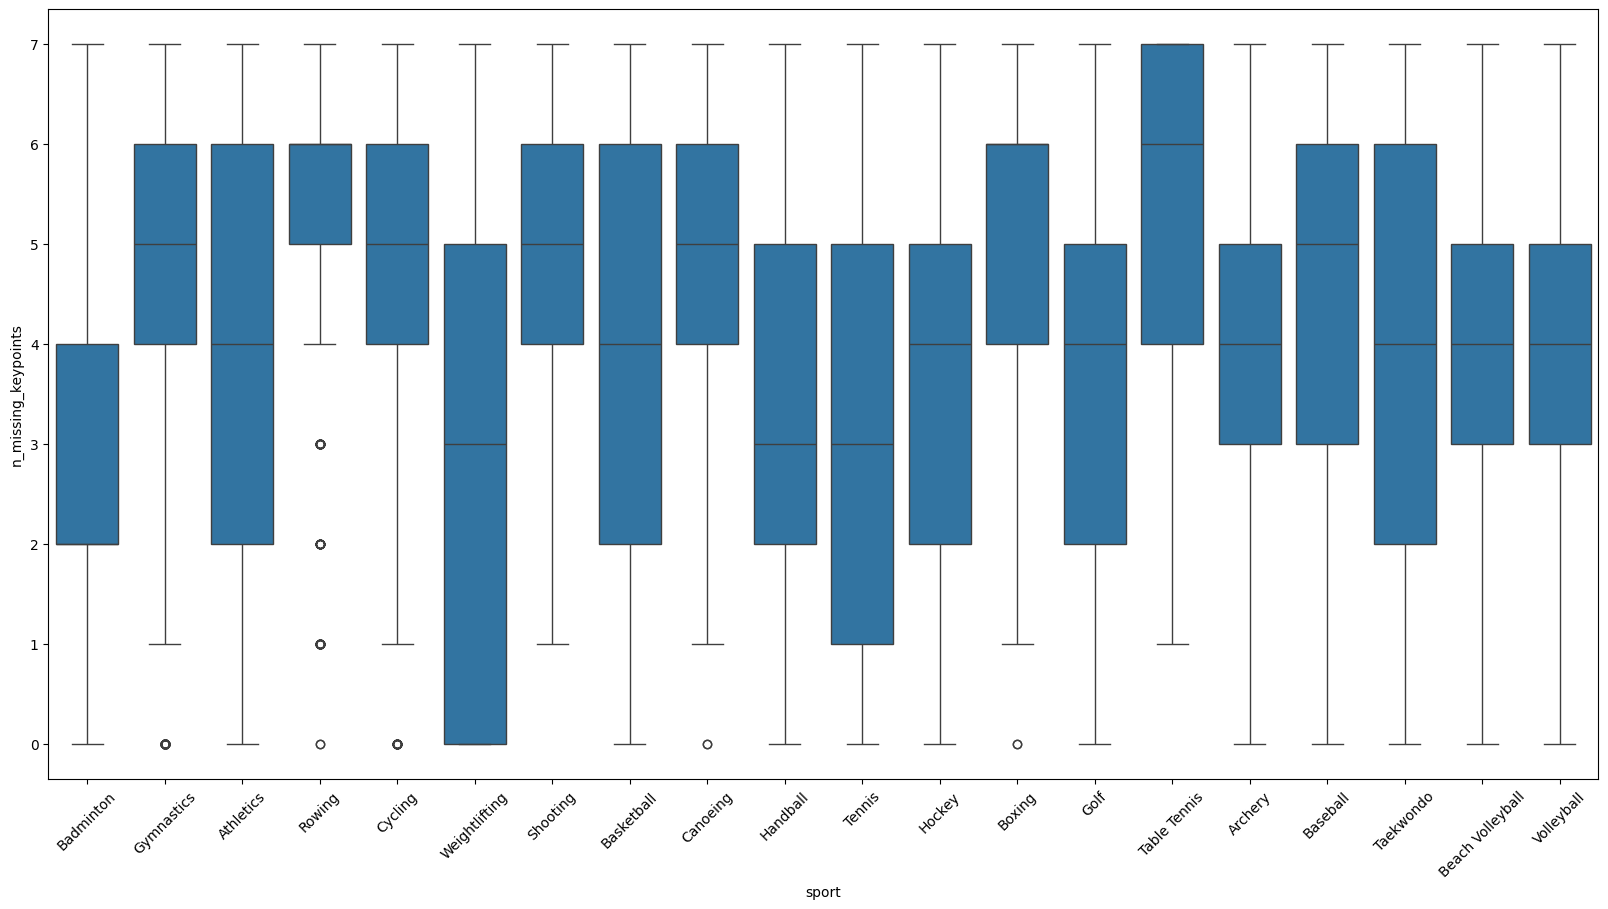

In [12]:
top_sports = poses_df.sport.value_counts().head(20).index
plt.figure(figsize=(20,10))
sns.boxplot(x="sport", y="n_missing_keypoints", data=poses_df[poses_df.sport.isin(top_sports)])
plt.xticks(rotation=45)
plt.show()

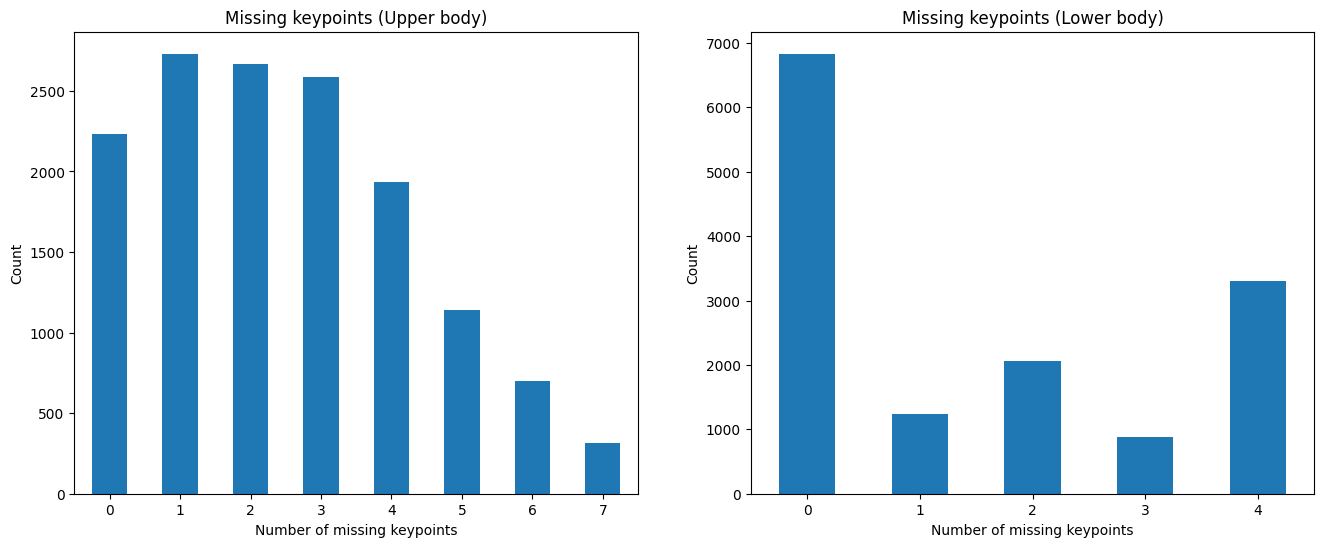

In [27]:
poses_df["n_miss_upper"] = poses_df.keypoints.map(lambda x: len([k for k in x[:13] if k[2] == 0])) # From top to hips included
poses_df["n_miss_lower"] = poses_df.keypoints.map(lambda x: len([k for k in x[13:] if k[2] == 0])) # Below hips (not included)

fig, ax = plt.subplots(1,2, figsize=(16,6))
poses_df["n_miss_upper"].value_counts().sort_index().plot(kind="bar", ax=ax[0])
ax[0].set_title("Missing keypoints (Upper body)")
ax[0].set_xlabel("Number of missing keypoints")
ax[0].set_ylabel("Count")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)

poses_df["n_miss_lower"].value_counts().sort_index().plot(kind="bar", ax=ax[1])
ax[1].set_title("Missing keypoints (Lower body)")
ax[1].set_xlabel("Number of missing keypoints")
ax[1].set_ylabel("Count")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

plt.show()


In [60]:
KEYPOINTS_NAMES = ["nose", "left_eye", "right_eye", "left_ear", "right_ear", 
                   "left_shoulder", "right_shoulder", "left_elbow", "right_elbow", 
                   "left_wrist", "right_wrist", "left_hip", "right_hip", 
                   "left_knee", "right_knee", "left_ankle", "right_ankle"]

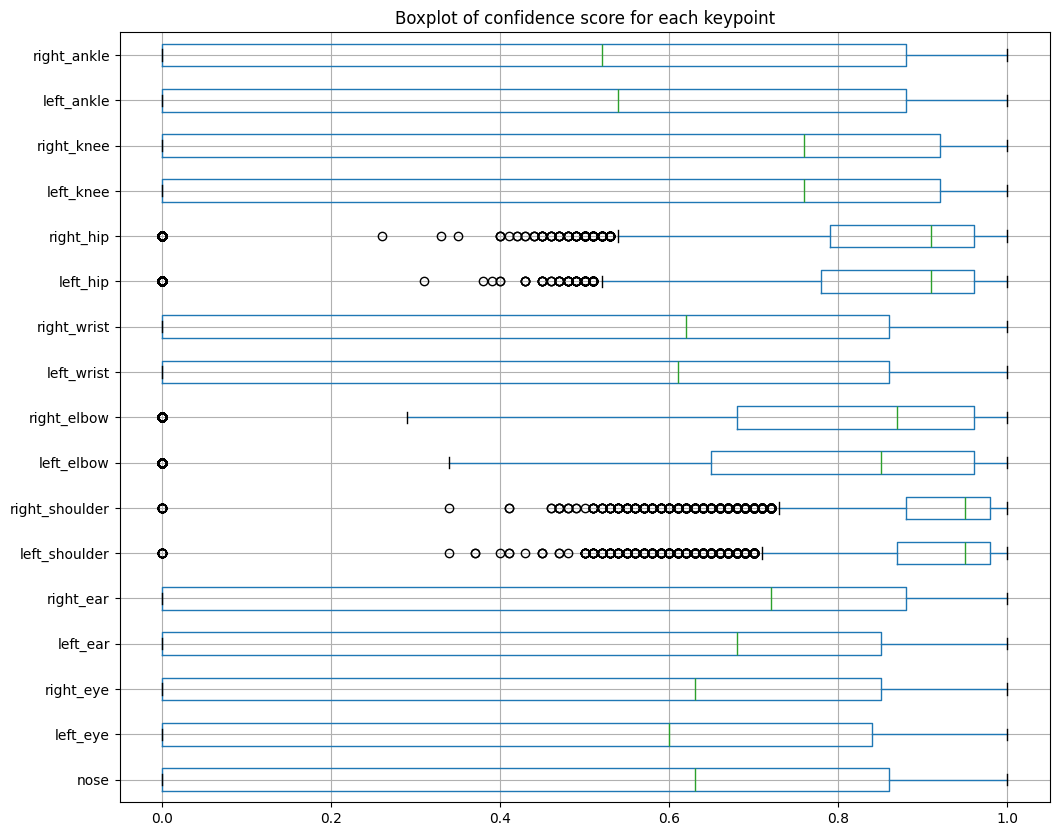

In [41]:
# For each keypoint, compute the number of missing keypoints
keypoints_df_scores = pd.DataFrame(poses_df["keypoints"].apply(lambda x: [k[2] for k in x]).tolist(), columns=KEYPOINTS_NAMES)
plt.figure(figsize=(12,10))
keypoints_df_scores.boxplot(column=KEYPOINTS_NAMES, vert=False)
plt.title("Boxplot of confidence score for each keypoint")
plt.show()


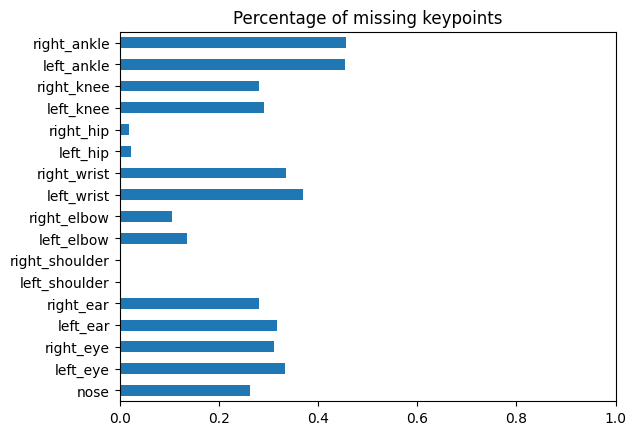

In [59]:
# For each keypoint, compute the number of missing keypoints
keypoints_df_missing = pd.DataFrame(keypoints_df_scores.apply(lambda x: x == 0), columns=KEYPOINTS_NAMES)
(keypoints_df_missing.sum() / len(keypoints_df_missing)).plot(kind="barh")
plt.title("Percentage of missing keypoints")
plt.xlim(0,1)
plt.show()